## **Exploratory Data Analysis**

This notebook serves as a prerequisite for modelling part of the project, we want to explore the relationships between attributes as well as data distributions  
and uncover what kind of data are we dealing with.

NOTE: Production-level visualizations will be iteratively developed after the drafts, this file serves as a draft of ideas for EDA.

In [1]:
import os
import sys

sys.dont_write_bytecode = True

import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from dotenv import load_dotenv

from sklearn.model_selection import train_test_split

load_dotenv()
sns.set_theme()
warnings.filterwarnings('ignore')

loading data

In [2]:
DATA_DIR = './Data/'
FILE = 'spotify_tracks_kaggle_weekly.csv'

In [3]:
data = pd.read_csv(DATA_DIR + FILE)

### Data separation

Splitting data into train and test sets, all analyses must be performed on train data as test set is simulation testing.

Replication of data split must have the same dataset as well as random_state

In [4]:
RANDOM_STATE = 21
TEST_SIZE = 0.1

In [5]:
y = data['popularity']
X = data.drop('popularity', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

setting data to X_train + y_train (working with training set)

In [7]:
data = pd.concat([X_train, y_train], axis=1)

### Null analysis

- Null representation in data
- dealing with null values

No NaN values

In [8]:
data.isnull().sum()

track_id            0
track_name          0
artist_name         0
year                0
artwork_url         0
album_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
track_url           0
language            0
popularity          0
dtype: int64

Nulls could be represented as -1 (some columns are defined in positive ranges -> -1 is null)

In [9]:
data.min()

track_id                                       0003ilHWJH7c5UtjKLPiC9
track_name                  "All That Is or Ever Was or Ever Will Be"
artist_name                       "Karaoke - Britney Spears, Madonna"
year                                                             1971
artwork_url                                      No artwork available
album_name                                "Enakke Enakkaa" Love Songs
acousticness                                                     -1.0
danceability                                                     -1.0
duration_ms                                                    5000.0
energy                                                           -1.0
instrumentalness                                                 -1.0
key                                                              -1.0
liveness                                                         -1.0
loudness                                                    -100000.0
mode                

occurances of -1 against shape

In [10]:
print("Data shape =", data.shape)
data.apply(lambda x: x == -1).sum()

Data shape = (56085, 22)


track_id             0
track_name           0
artist_name          0
year                 0
artwork_url          0
album_name           0
acousticness        31
danceability        31
duration_ms          0
energy              31
instrumentalness    31
key                 31
liveness            31
loudness             0
mode                31
speechiness         31
tempo               31
time_signature      31
valence             31
track_url            0
language             0
popularity           0
dtype: int64

selection of columns in which nulls are represented as -1

In [11]:
null_columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'key',
                'liveness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

or programatically: only negative value in column is -1

In [12]:
copy = data.copy().apply(lambda x: pd.to_numeric(x, errors='coerce'))

only_negative_values_one = copy[(copy < 0) & (copy == -1)]

deleting null values for EDA purposes

In [107]:
data.shape

(56085, 22)

#### Popularity & Language distribution analysis

interestingly enough most of the songs are labeled with popularity = 0

<Axes: >

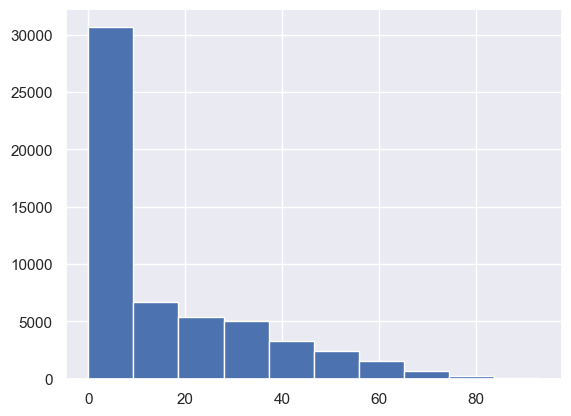

In [108]:
data['popularity'].hist()

<Axes: xlabel='language'>

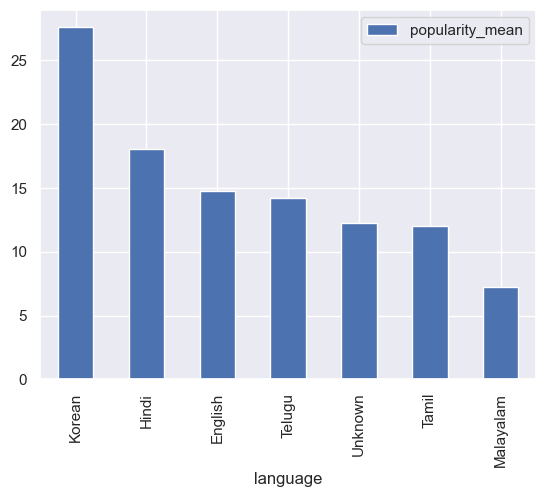

In [109]:
language_popularity = data.groupby('language').agg(
    popularity_mean = ('popularity', 'mean')
)

language_popularity.sort_values(by='popularity_mean', ascending=False).plot.bar()

Popularity across song release date - averaging aggregation

<Axes: xlabel='year'>

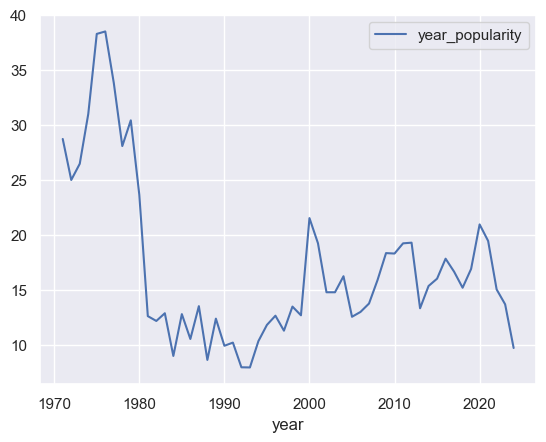

In [110]:
popularity_by_year = data.groupby('year').agg(
    year_popularity = ('popularity', 'mean')
)

popularity_by_year.plot()

we should investigate the counts bias -> we compare the counts of songs in that particular year to the popularity value to see if the popularity is not large
due to high count

Text(0.5, 0.98, 'Popularity based on year of release\nplot below describes counts of tracks in the corresponding year')

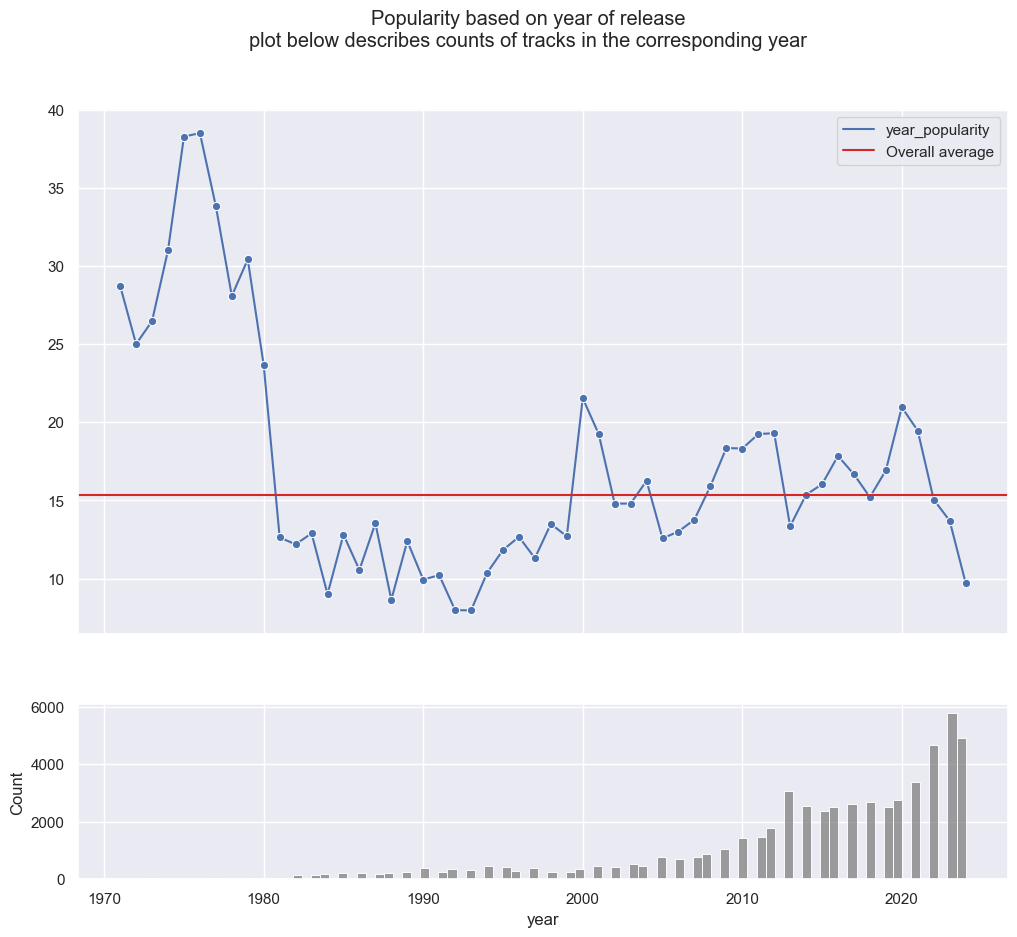

In [111]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

sns.lineplot(data=popularity_by_year, ax=ax[0], marker='o')
sns.histplot(data=data, x='year', color='grey')

ax[0].axhline(y=data['popularity'].mean(), color='tab:red', label='Overall average')

ax[0].legend()

fig.suptitle('Popularity based on year of release\nplot below describes counts of tracks in the corresponding year')

There could be bias due to the very strong imbalance of counts against the aggregated values.

Although not uniform, language distribution is roughly balanced with english not having overwhelming majority.

<Axes: xlabel='language'>

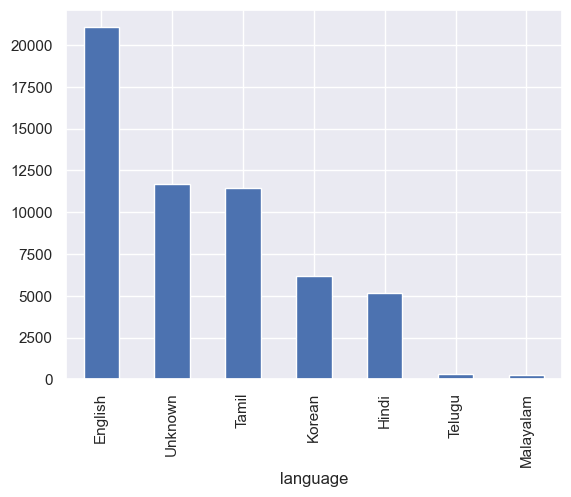

In [112]:
data['language'].value_counts().plot.bar()

### Distribution analysis

In [113]:
numeric_data = data[data.columns[data.dtypes != object]]
categorical_data = data[data.columns[data.dtypes == object]]

In [114]:
print(numeric_data.shape)
print(categorical_data.shape)

(56085, 15)
(56085, 7)


We will analyse the distribution estimation together with some other transformations which could be useful in production modelling.

Input distribution will be tested against:

1. Logarithmic transform
2. Square root transform

In [115]:
def custom_log_transform(X, epsilon=None):

    if epsilon is None:
        epsilon = abs(X.min()) + 1

    X_log = np.log(X + epsilon)

    return X_log


def custom_sqrt_transform(X, epsilon=None):

    if epsilon is None:
        epsilon = abs(X.min()) + 1

    X_sqrt = np.sqrt(X + epsilon)

    return X_sqrt

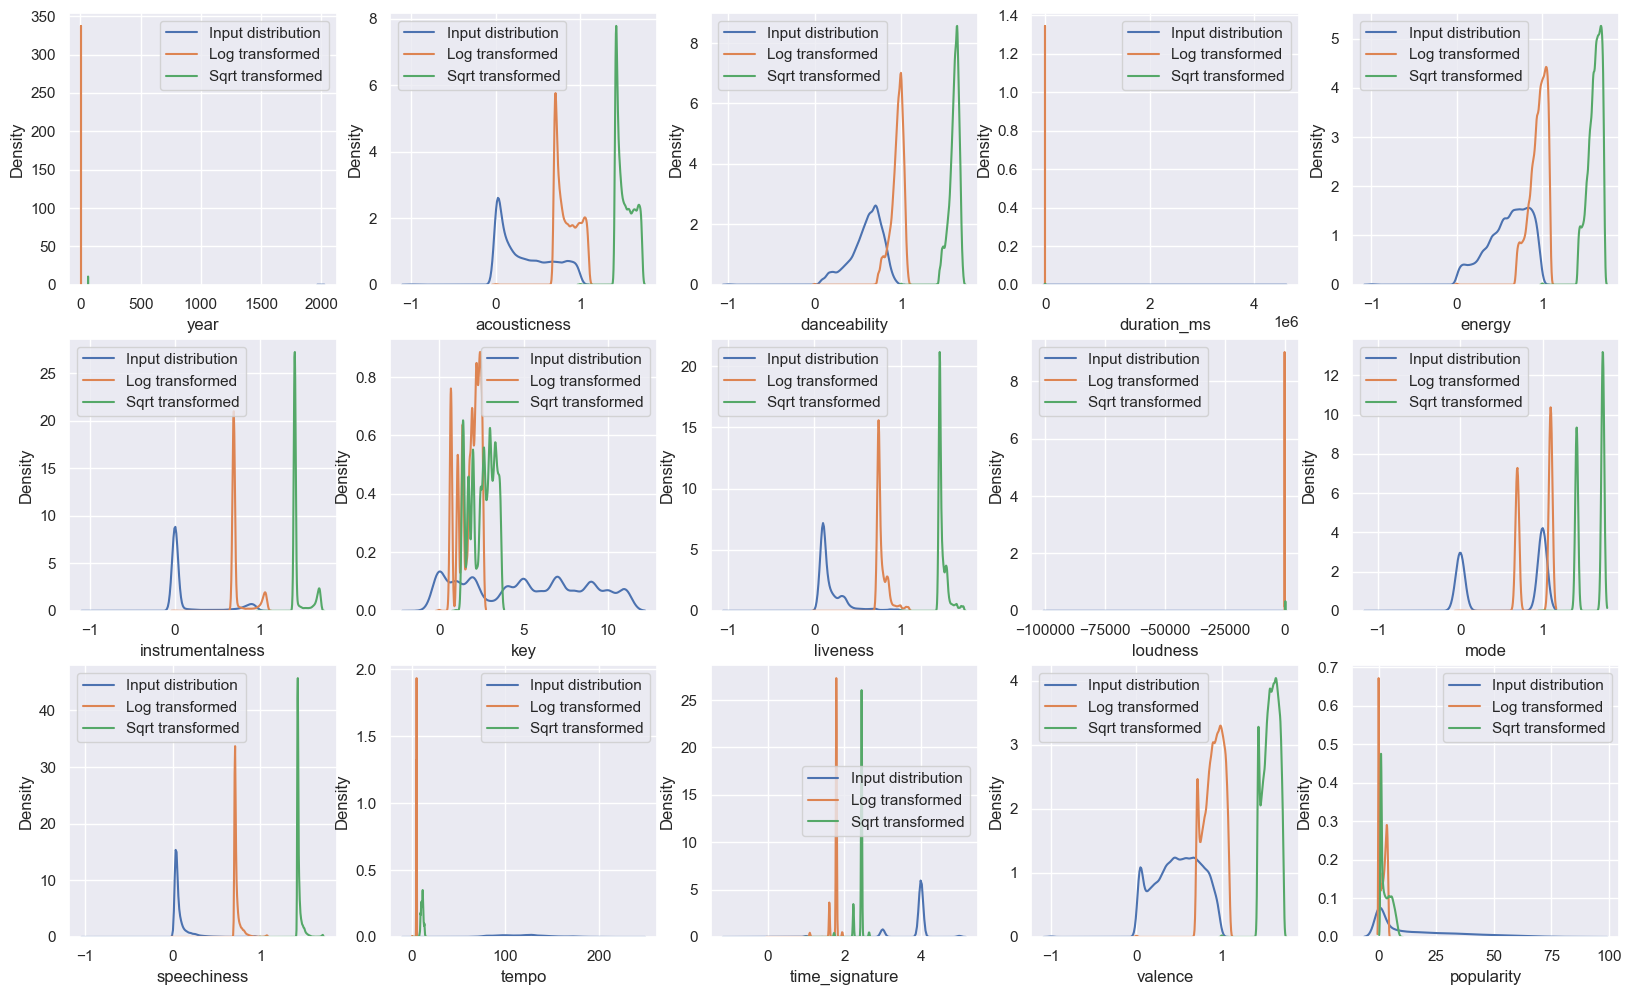

In [116]:
fig, axs = plt.subplots(3, 5, figsize=(20, 12))

axs = axs.flatten()

for i, col in enumerate(numeric_data.columns):
    
    column = numeric_data[col]

    sns.kdeplot(data=column, ax=axs[i], label='Input distribution')
    sns.kdeplot(data=custom_log_transform(column), ax=axs[i], label='Log transformed')
    sns.kdeplot(data=custom_sqrt_transform(column), ax=axs[i], label='Sqrt transformed')

    axs[i].legend()

Interestingly enough, transformations did not improve the data distributions... analysis of input distributions could be useful (wether we are dealing with predefined ranges for example which cannot have outliers)

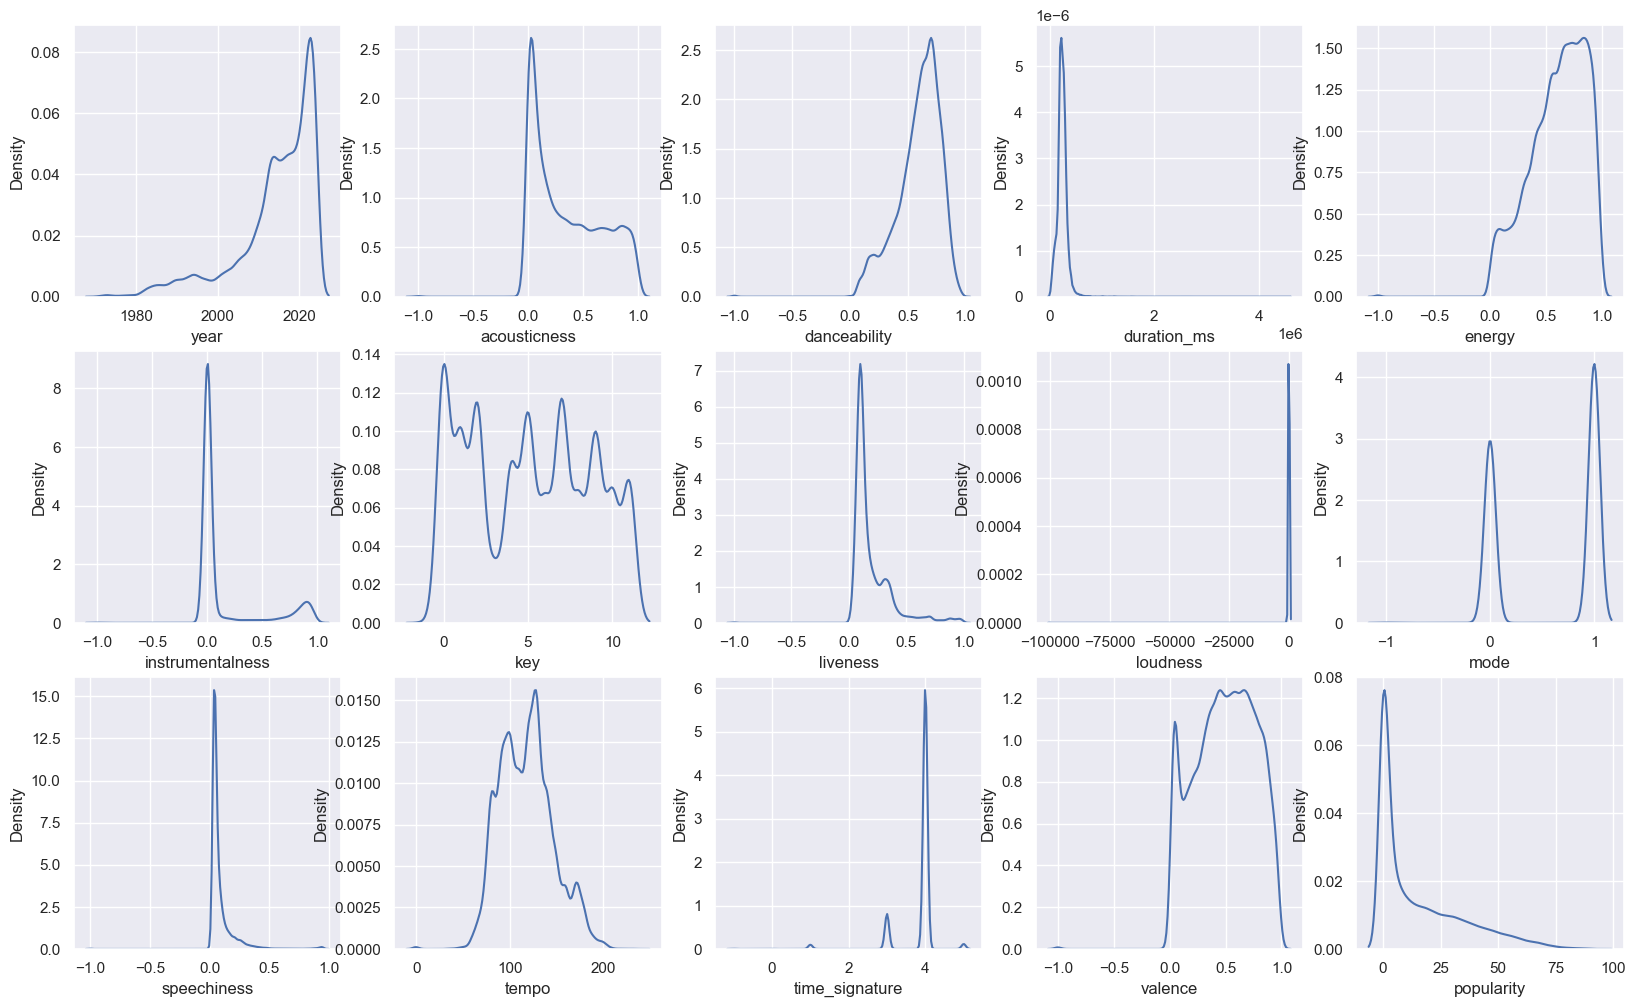

In [117]:
fig, axs = plt.subplots(3, 5, figsize=(20, 12))

axs = axs.flatten()

for i, col in enumerate(numeric_data.columns):
    
    column = numeric_data[col]

    sns.kdeplot(data=column, ax=axs[i], label='Input distribution')
    #sns.kdeplot(data=custom_log_transform(column), ax=axs[i], label='Log transformed')
    #sns.kdeplot(data=custom_sqrt_transform(column), ax=axs[i], label='Sqrt transformed')

    

categorical columns distribution analysis, we will also remove all columns wich are unique or have % variance above certain treshold

In [16]:
variance_treshold = 0.95

In [17]:
categorical_data.apply(lambda x: x.nunique() / x.shape[0])

track_id       0.998748
track_name     0.666287
artist_name    0.200796
artwork_url    0.338752
album_name     0.319303
track_url      0.998748
language       0.000112
dtype: float64

In [18]:
for i, col in enumerate(categorical_data.columns):

    column = categorical_data[col]

    if column.is_unique:
        print(col, "is unique -> will skip calculation -> column to be DROPPED")
        continue

    col_variance = column.nunique() / column.shape[0]

    if col_variance >= variance_treshold:
        print(col, f"has variance var={col_variance} above treshold={variance_treshold} --> skipping --> column to be DROPPED (further analysis whether drop should be executed is required)")
        continue


track_id has variance var=0.9987483351252467 above treshold=0.95 --> skipping --> column to be DROPPED (further analysis whether drop should be executed is required)
track_url has variance var=0.9987483351252467 above treshold=0.95 --> skipping --> column to be DROPPED (further analysis whether drop should be executed is required)


#### Interquantile range analysis - outliers

In [19]:
print(numeric_data.shape)

(62317, 15)


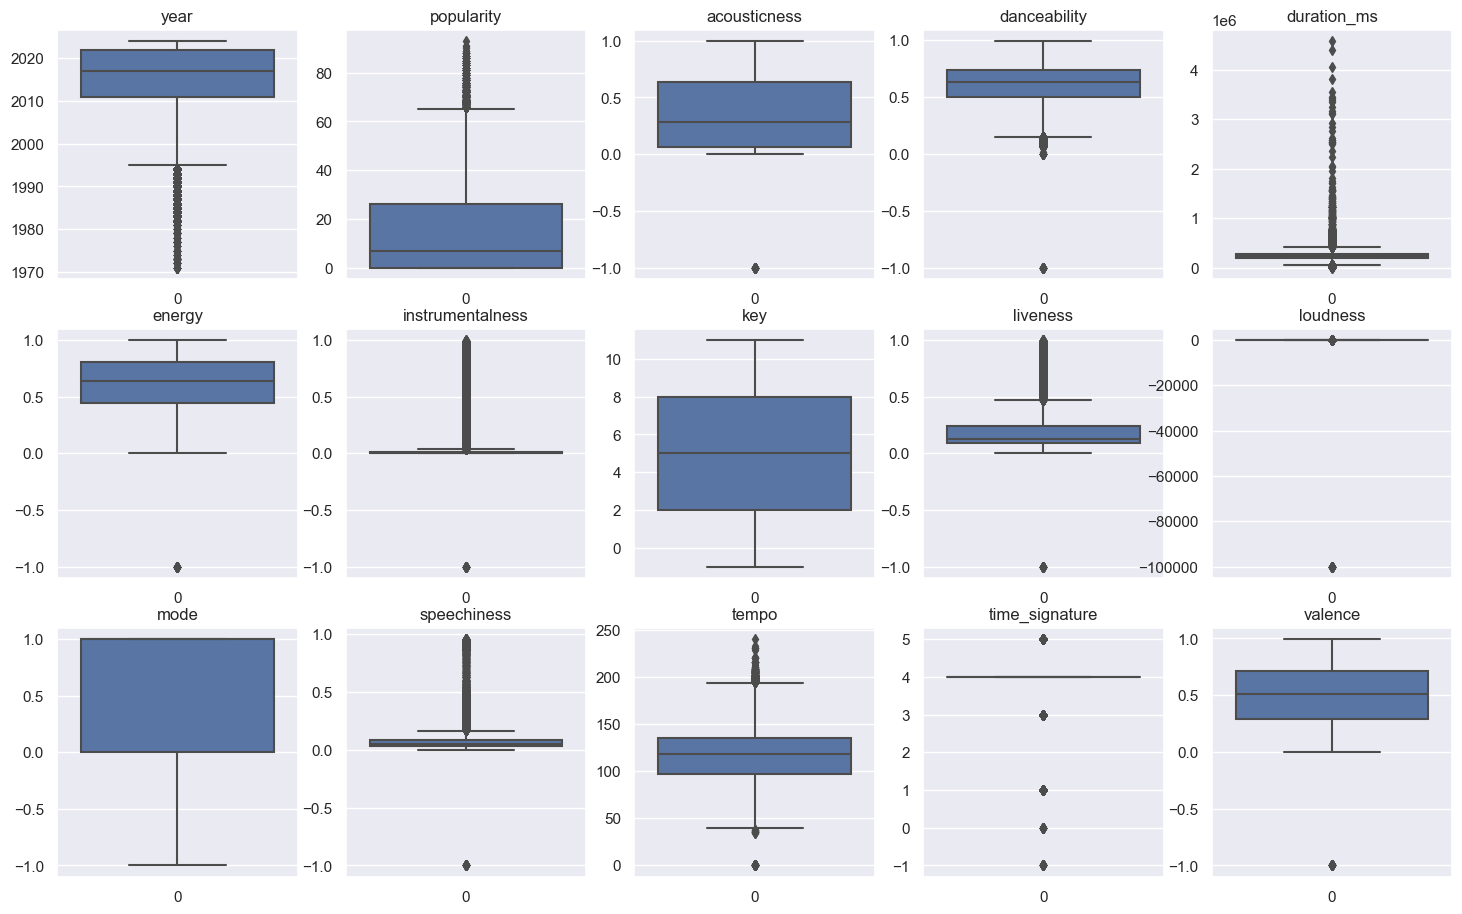

In [20]:
fig, ax = plt.subplots(3, 5, figsize=(18, 11))

ax = ax.flatten()

for i, col in enumerate(numeric_data.columns):

    column = numeric_data[col]

    sns.boxplot(data=column, ax=ax[i])
    ax[i].set_title(col)

outiers are present in the dataset

### Correlation analysis

<Axes: >

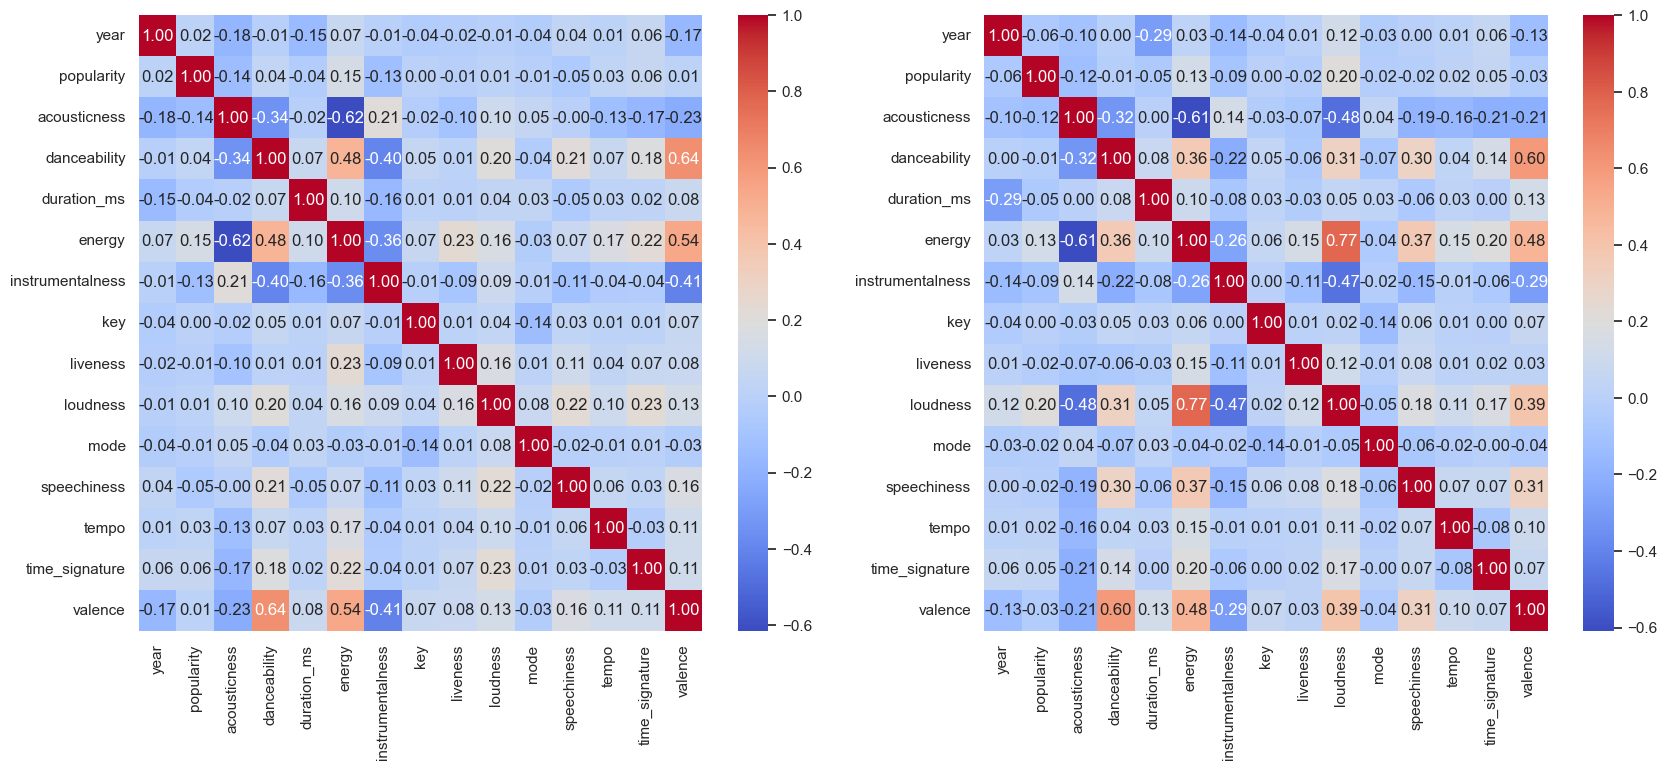

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

pearson = numeric_data.corr(method='pearson')
spearman = numeric_data.corr(method='spearman')

sns.heatmap(pearson, annot=True, fmt='.2f', cmap='coolwarm', ax=axs[0])
sns.heatmap(spearman, annot=True, fmt='.2f', cmap='coolwarm', ax=axs[1])

### Normality testing

Shapiro-Wilk normality tests -> we will use p-value treshold = 5%

In [22]:
from scipy.stats import shapiro

In [25]:
p_value_treshold = 0.05

In [41]:
for col in numeric_data:
    
    column = numeric_data[col]

    _, p_value = shapiro(column)

    if p_value < p_value_treshold:
        print(f"Rejects hypothesis H0 for column {col:<20} with p-value = {p_value:.3f} ---> NO NORMAL DISTRIBUTION")

Rejects hypothesis H0 for column year                 with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column popularity           with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column acousticness         with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column danceability         with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column duration_ms          with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column energy               with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column instrumentalness     with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column key                  with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column liveness             with p-value = 0.000 ---> NO NORMAL DISTRIBUTION
Rejects hypothesis H0 for column loudness             with p-value = 0.00

well.... rip xD, transformations will be required